In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.14, M2=2111.43


In [2]:
agg = gp.Model("agg")
agg.setParam("MIPGap", 1e-7)

a = agg.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
zeta = agg.addVars(T, S, vtype=GRB.BINARY, name="zeta")
eta = agg.addVars(T, S, vtype=GRB.BINARY, name="eta")

agg.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum(1 / S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s])
                  for t, s in product(range(T), range(S)))

agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) + gd[t, s] >= bp[t, s] + gc[t, s])
    agg.addConstr(bm[t, s] <= M2 * eta[t, s])
    agg.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    agg.addConstr(gc[t, s] <= M2 * zeta[t, s])
    agg.addConstr(gd[t, s] <= M2 * (1 - zeta[t, s]))
    agg.addConstr(g[t, s] <= sum(K))
    agg.addConstr(g[t, s] >= 0)
for s in range(S):
    agg.addConstr(g[0, s] == sum(K0) + gc[0, s] - gd[0, s])
    agg.addConstr(gd[0, s] <= sum(K0))
for t, s in product(range(1, T), range(S)):
    agg.addConstr(g[t, s] == g[t - 1, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gd[t, s] <= g[t - 1, s])
    
agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

a_vals = np.array([a[t].X for t in range(T)])
bp_vals = np.array([[bp[t, s].X for s in range(S)] for t in range(T)])
bm_vals = np.array([[bm[t, s].X for s in range(S)] for t in range(T)])
g_vals  = np.array([[g[t, s].X  for s in range(S)] for t in range(T)])
gc_vals = np.array([[gc[t, s].X for s in range(S)] for t in range(T)])
gd_vals = np.array([[gd[t, s].X for s in range(S)] for t in range(T)])

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-09
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 4800 rows, 3384 columns and 11480 nonzeros
Model fingerprint: 0x8715cac7
Variable types: 2424 continuous, 960 integer (960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Found heuristic solution: objective 1165706.3683
Presolve removed 1860 rows and 640 columns
Presolve time: 0.01s
Presolved: 2940 rows, 2744 columns, 8360 nonzeros
Variable types: 2064 continuous, 680 integer (680 binary)

Root relaxation: objective 1.762301e+06, 1585 iteration

In [3]:
da_profit = sum(P_DA[t] * a[t].X for t in range(T))
rt_profit = sum(P_RT[t, s] * bp[t, s].X / S for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * bm[t, s].X / S for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost
print("[AGGREGATION MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[AGGREGATION MODEL]
DA Profit      = 278459.78
RT Profit      = 1486895.47
Penalty Cost   = 4650.21
Total Profit   = 1760705.05



[AGG MODEL] Day-Ahead Commitment (alpha values):
TOTAL: 1850.43


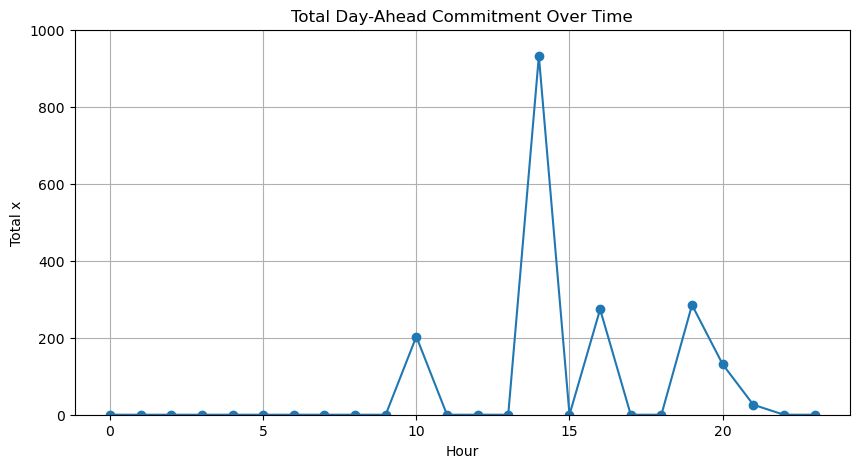

In [7]:
print("\n[AGG MODEL] Day-Ahead Commitment (alpha values):")
total_agg_commit = 0
for t in range(T):
    alpha_t = a[t].X
    total_agg_commit += alpha_t
    # print(f"Time {t}: {alpha_t:.2f}")
print(f"TOTAL: {total_agg_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), a_vals, marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1000)
plt.grid(True)
plt.show()

In [10]:
for t in range(13,15):
    for s in range(0,3):
        sum_R = R[:, t, s].sum()
        alpha_val = a[t].X
        bp_val = bp[t, s].X
        bm_val = bm[t, s].X
        gc_val = gc[t, s].X
        gd_val = gd[t, s].X

        lhs = sum_R - alpha_val
        rhs = bp_val - bm_val + gc_val - gd_val

        print(f"[t={t:02d}, s={s:02d}]  ∑R={sum_R:.2f}, α={alpha_val:.2f}, β⁺={bp_val:.2f}, β⁻={bm_val:.2f}, γᶜ={gc_val:.2f}, γᴰ={gd_val:.2f}")
        # print(f"              LHS = {lhs:.2f}, RHS = {rhs:.2f}")

[t=13, s=00]  ∑R=1426.74, α=0.00, β⁺=1926.74, β⁻=0.00, γᶜ=0.00, γᴰ=500.00
[t=13, s=01]  ∑R=1456.22, α=0.00, β⁺=1758.56, β⁻=0.00, γᶜ=0.00, γᴰ=302.34
[t=13, s=02]  ∑R=1378.87, α=0.00, β⁺=1878.87, β⁻=0.00, γᶜ=0.00, γᴰ=500.00
[t=14, s=00]  ∑R=1553.81, α=931.63, β⁺=122.17, β⁻=0.00, γᶜ=500.00, γᴰ=0.00
[t=14, s=01]  ∑R=1233.97, α=931.63, β⁺=0.00, β⁻=0.00, γᶜ=302.34, γᴰ=0.00
[t=14, s=02]  ∑R=1465.60, α=931.63, β⁺=33.97, β⁻=0.00, γᶜ=500.00, γᴰ=0.00


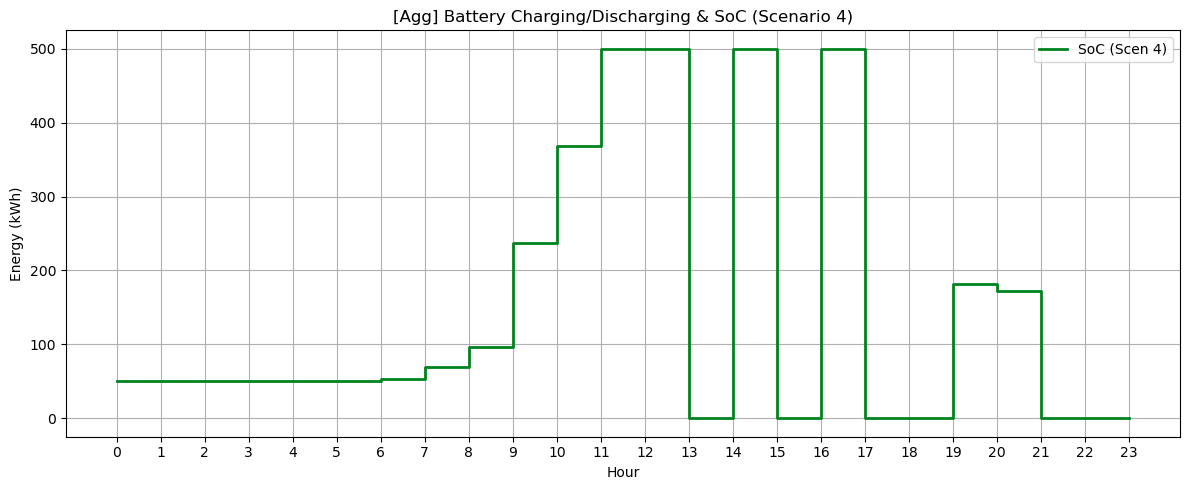

In [9]:
s = 4
gc_single = gc_vals[:, s]  # (T,)
gd_single = gd_vals[:, s]
g_single  = g_vals[:, s]
hours = np.arange(T)

plt.figure(figsize=(12, 5))
# plt.step(hours, gc_single, where='post', label=f"Charge (Scen {s})", marker='^')
# plt.step(hours, gd_single, where='post', label=f"Discharge (Scen {s})", marker='v')
plt.step(hours, g_single, where='post', label=f"SoC (Scen {s})", color='#00821E', linewidth=2)

plt.title(f"[Agg] Battery Charging/Discharging & SoC (Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()